# EDA Notebook

## Introduction
This eda covers mainly 3 things:

1) Checking for Dataset quality

2) Data Preparation

3) EDA

4) Summarized Insights on data

The goal of this is to **Identify potential repeat buyers** using the *Brazillian E-Commerce Olist Store* Dataset and to derive meaningful insights of data mining.

Goals in my data mining would be to:

1) Identify impactful and non-impactful features for feature engineering

2) Derive data driven insights

3) Provide a summarized overview of my findings and probable steps for feature engineering

# Libraries & Files & Error Handling

In [170]:
import sys

def check_interpreter_details():
    try:
        # Check Python version
        print("Python version:", sys.version)
        print("Interpreter is connected and working.")
    except Exception as e:
        print("Interpreter is not connected or an error occurred. Error:", e)

check_interpreter_details()

Python version: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]
Interpreter is connected and working.


In [171]:
try:
    # Data Processing/Analysis
    import numpy as np
    import pandas as pd
    from googletrans import Translator
    from sklearn.linear_model import LinearRegression
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    # Graphing
    import matplotlib.pyplot as plt
    import seaborn as sns

except Exception as e:
    print(f"Error occurred: {e}")

In [172]:
try:
    folder_path = r"src\dataprep\rawdata"

    customers_df = pd.read_csv(folder_path + r'\olist_customers_dataset.csv')
    location_df = pd.read_csv(folder_path + r'\olist_geolocation_dataset.csv')
    items_df = pd.read_csv(folder_path + r'\olist_order_items_dataset.csv')
    payment_df = pd.read_csv(folder_path + r'\olist_order_payments_dataset.csv')
    review_df = pd.read_csv(folder_path + r'\olist_order_reviews_dataset.csv')
    order_df = pd.read_csv(folder_path + r'\olist_orders_dataset.csv')
    product_df = pd.read_csv(folder_path + r'\olist_products_dataset.csv')
    seller_df = pd.read_csv(folder_path + r'\olist_sellers_dataset.csv')
    tr_df = pd.read_csv(folder_path \
                                + r'\product_category_name_translation.csv')
except FileNotFoundError:
    print(f'File not at folder path: {folder_path}')
except Exception as e:
    print(f'Error Occured: {e}')

# Data Quality

## Null/Empty/Duplicated Values Report

In [173]:
df_dict = {
    "customers_df": customers_df, 
    "location_df": location_df, 
    "items_df": items_df, 
    "payment_df": payment_df, 
    "review_df": review_df, 
    "order_df": order_df, 
    "product_df": product_df, 
    "seller_df": seller_df, 
    "translation_df": tr_df
    }

In [174]:
# Generate a Duplicate/Null/Empty Value Report for each DF
summary = []

for k, v in df_dict.items():
    shape = v.shape
    null_val_count = v.isnull().any(axis=1).sum()
    null_col_count = v.isnull().any().sum()
    null_list = v.columns[v.isnull().any()].tolist()
    dupe = v.shape[0] - v.drop_duplicates().shape[0]
    
    summary.append({
        "DataFrame": k,
        "Shape": shape,
        "Duplicate Rows": dupe,
        "Rows with Null Values": null_val_count,
        "Cols with Null Values": null_col_count,
        "Name of Null Cols": null_list
        })
    
# Prevent the DataFrame from being truncated
pd.set_option('display.expand_frame_repr', False)
pd.DataFrame(summary).style \
    .set_properties(**{'text-align': 'left'}) \
    .set_table_styles(
    [{'selector': 'th', 'props': [('text-align', 'left')]}]
)

,DataFrame,Shape,Duplicate Rows,Rows with Null Values,Cols with Null Values,Name of Null Cols
0,customers_df,"(99441, 5)",0,0,0,[]
1,location_df,"(1000163, 5)",261831,0,0,[]
2,items_df,"(112650, 7)",0,0,0,[]
3,payment_df,"(103886, 5)",0,0,0,[]
4,review_df,"(99224, 7)",0,89385,2,"['review_comment_title', 'review_comment_message']"
5,order_df,"(99441, 8)",0,2980,3,"['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']"
6,product_df,"(32951, 9)",0,611,8,"['product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']"
7,seller_df,"(3095, 4)",0,0,0,[]
8,translation_df,"(71, 2)",0,0,0,[]


### **Summary:** 
1) All datasets have no duplicated data except `location_df`, which takes up about ~26% of the dataset
2) Null values are present in `review_df`, `order_df` and `product_df`; and with No of Cols w/ null values existing in 2, 3 and 8 Cols respectively. Surprisingly, `product_df`, though has higher no. of cols with null values, has the least number of null values. With `review_df` showing the opposite relationship, having the lowest No of Cols w/ null values and the highest rows w/ null values, coming to about 90% of the dataset having null values in either column.

## Errorneous Values

Just skimming thru the whole dataset, it seems that the location DF is filled with errors

In [175]:
print("Number of states:", location_df["geolocation_state"].unique().size)

Number of states: 27


In [176]:
summary = []

# Loop through each state code
for state_code in location_df["geolocation_state"].unique():
    # Get unique city names
    unique_cities = location_df[location_df["geolocation_state"] == state_code] \
                               ["geolocation_city"].unique().tolist()

    summary.append({
        "state_code": state_code,
        "unique_cities": unique_cities,
        "no_of_cities": len(unique_cities)
    })

pd.DataFrame(summary).head(3)


,state_code,unique_cities,no_of_cities
0,SP,"[sao paulo, são paulo, sao bernardo do campo, ...",1048
1,RN,"[são paulo, natal, parnamirim, sao jose de mip...",214
2,AC,"[sao paulo, rio de janeiro, sena madureira, ri...",34


### **Summary**
There are a lot of wrongly named city names and also wrong city names in different state codes. Just by mainly looking at `SP` and without even showing all, we can see that there are spelling errors heavily existing. Thankfully, it seems that it can just be generalized with `geolocation_state` without suffering from overgeneralization as some cities have evidently more cities than others.  Additionally, this also drastically decreases the feature size of such categorical features, which when overspecific, will affect the model accuracy. Additionally, we can map the city zip codes to the customers, ensuring that we only use 1 dataset as the "ground truth".

# Data Preparation

Here, we look at the data as a whole, rather than in its principal components. Ultimately we are finding for potential repeat customers so information like specific geospatial information (longitude and latitude) may be useless to an extent. 

In [177]:
# Just to prevent errors from duplicated values from here onwards
location_df = location_df.drop_duplicates()

In [178]:
# List of DF to merge together
merge_info = [
    (customers_df, 'customer_id', 'customer_id'),
    (payment_df, 'order_id', 'order_id'),
    (review_df, 'order_id', 'order_id'),
    (items_df, 'order_id', 'order_id'),
    (product_df, 'product_id', 'product_id'),
    (seller_df, 'seller_id', 'seller_id'),
]

# # Initialize merged_df with the order_df
df = order_df

# Loop through each DataFrame and merge
for merge_df, left_key, right_key in merge_info:
    df = df.merge(merge_df, left_on=left_key, right_on=right_key, how='left')

In [179]:
df.shape

(119143, 39)

In [180]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'order_item_id',
       'product_id', 'seller_id', 'shipping_limit_date', 'price',
       'freight_value', 'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state'],
      dtype='object')

In [181]:
# Drop redundant columns
df = df.drop(columns=['customer_id', 'order_approved_at',
                      'order_delivered_carrier_date', 'customer_city',
                      'customer_state', 'payment_sequential',
                      'review_creation_date', 'review_answer_timestamp',
                      'review_comment_title', 'review_comment_message',
                      'product_name_lenght', 'seller_city', 'seller_state',
                      'shipping_limit_date'])
original_df_size = df.shape
original_df_size

(119143, 25)

## **Summary:**
After merging all the datasets together, it turns out that there really isnt any column that can clearly indicate clearly whether someone has bought twice or not. This does mean that we would have to create a feature that somehow is able to represent customers that have repurchased. 

Eventually, I came up with 3 possible scenarios to represent repeat buyers

- **Solution A: Customers per unique order**
- **Soltuion B: Customers per unique item bought**
- **Solution C: Customers by repurchase from same seller**

### **Functions**

In [182]:
def barchart(axis, dataset, column, title, x_label, y_label, type):
    sorted_df = dataset[column].value_counts().sort_index()

    sorted_df.plot(kind='bar', edgecolor='k', alpha=0.7, ax=axis)
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.grid(axis='y', linestyle='--', alpha=0.7)

    # Calculate statistics
    mean, std_dev, mode = sorted_df.mean(), sorted_df.std(), sorted_df.idxmax()
    
    # Annotate with values
    padding = 1000  # Adjust padding
    if type == 0:
        for idx, value in enumerate(sorted_df):
            percentage = (value / sorted_df.sum()) * 100
            axis.text(idx, value + padding, f'{percentage:.1f}%', ha='center')
    else:
        for idx, value in enumerate(sorted_df):
            axis.text(idx, value + padding, str(value), ha='center')

    # Rotate x-axis labels to face straight up
    axis.set_xticklabels(sorted_df.index, rotation=0)

    # Add mean, std deviation, and mode below the graph
    stats_text = f"Mean: {mean:.2f}\nStd Dev: {std_dev:.2f}\nMode: {mode}"
    axis.text(0.5, -0.2, stats_text, ha='center', va='center',
              transform=axis.transAxes, fontsize=10)

    # Add mean and standard deviation lines
    axis.axhline(mean, color='r', linestyle='--', linewidth=1, 
                 label=f'Mean: {mean:.2f}')
    axis.axhline(mean + std_dev, color='g', linestyle='--', linewidth=1, 
                 label=f'Mean + 1 Std Dev: {mean + std_dev:.2f}')
    
    axis.legend() # Add legend

def remove_cancelled_count(df, key, value, type):
      # Exclude canceled orders
      filtered_df = df[(df['order_status']!='canceled') 
                       & (df['order_status']!='unavailable')]

      if type == 1:
            # Count unique value from each customer's ID
            result = filtered_df.groupby(key)[value].nunique().reset_index()
      
      if type == 2:
            # Group by customer_id and seller_id and count unique order_id
            result = filtered_df.groupby([key, 'seller_id'])[value] \
                                .nunique().reset_index()
            # Because rightmost column is order_id and not count yet
            result['order_id'] = result['order_id'] - 1

      # Rename the last column for modularization
      result.rename(columns={result.columns[-1]: 'count'}, inplace=True)

      return result

## **Finding Number of purchases by a customer**

In [183]:
temp_df = df[['customer_unique_id', 'order_id', 'order_status']]

temp_df['order_status'].unique() # Checking for errors

array(['delivered', 'invoiced', 'shipped', 'processing', 'unavailable',
       'canceled', 'created', 'approved'], dtype=object)

Data in `order_status` matches the given code list in the data dictionary which is great. So to identify products that have been purchased, would mean to exclude those `canceled` & `unavailable` orders

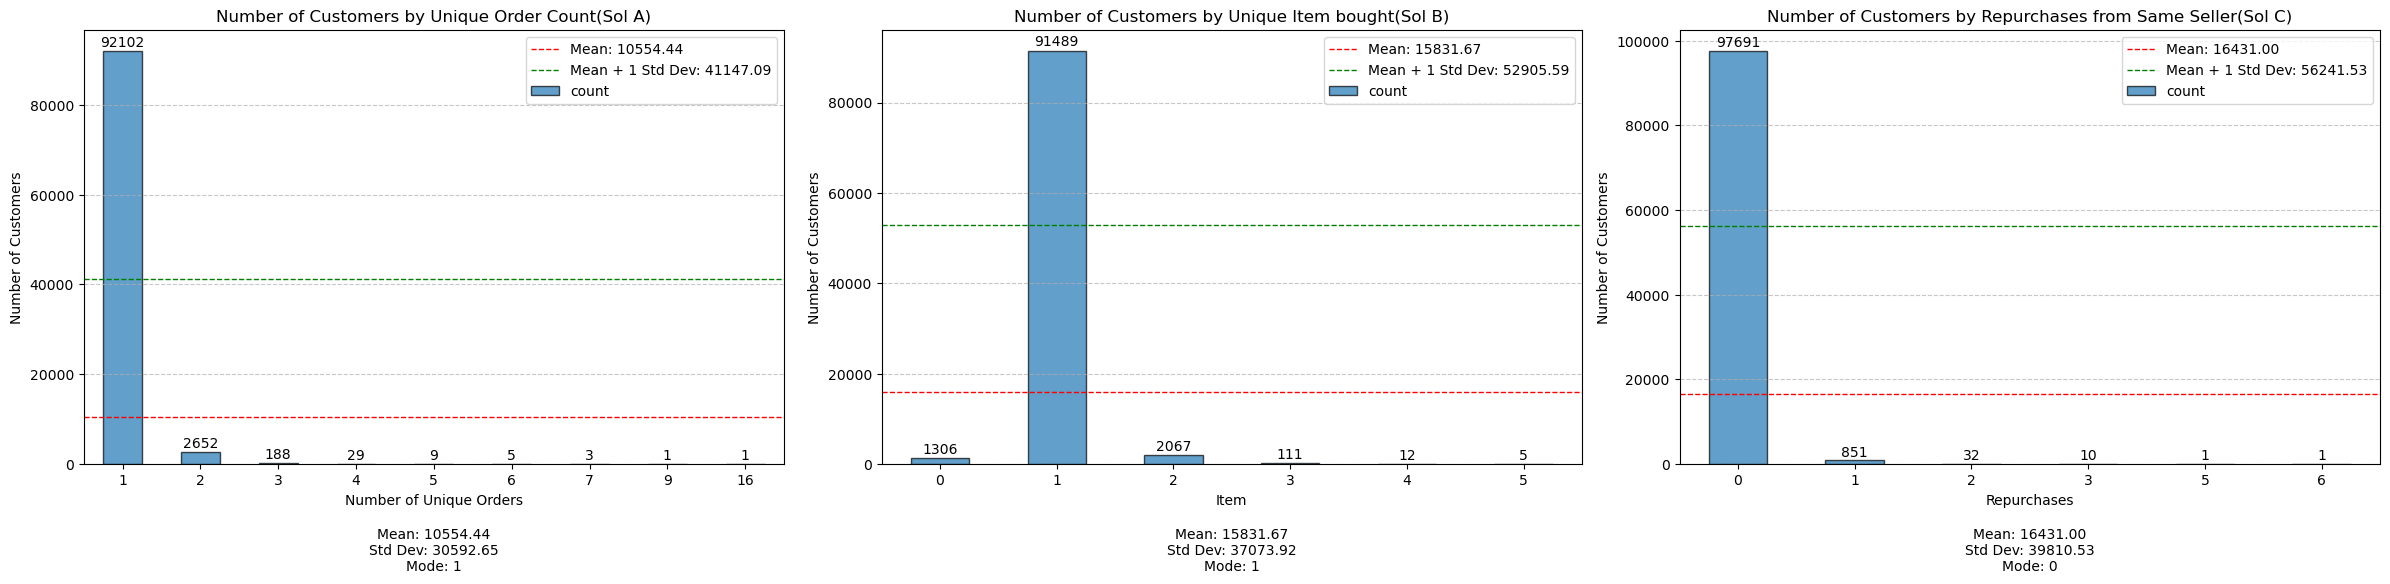

In [184]:
# Assuming df is your DataFrame
temp_df1 = df[['customer_unique_id', 'order_id', 'order_status']]
temp_df2 = df[['customer_unique_id', 'product_category_name', 'order_status']]
temp_df3 = df[['customer_unique_id', 'order_id', 'seller_id', 'order_status']]

key1, value1 = 'customer_unique_id', 'order_id'
key2, value2 = 'customer_unique_id', 'product_category_name'
key3, value3 = 'customer_unique_id', 'order_id'

result1 = remove_cancelled_count(temp_df1, key1, value1, 1)
result2 = remove_cancelled_count(temp_df2, key2, value2, 1)
result3 = remove_cancelled_count(temp_df3, key3, value3, 2)

# Create 3 subplots in a row
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

barchart(axs[0], result1, 'count', 
         'Number of Customers by Unique Order Count(Sol A)',
         'Number of Unique Orders', 'Number of Customers', 1)

barchart(axs[1], result2, 'count', 
         'Number of Customers by Unique Item bought(Sol B)',
         'Item', 'Number of Customers', 1)

barchart(axs[2], result3, 'count', 
         'Number of Customers by Repurchases from Same Seller(Sol C)',
         'Repurchases', 'Number of Customers', 1)

# Display
plt.tight_layout()
plt.show()

#### **Summary:**
Unfortunately, it seems that across all 3 different types of deductions, the dataset is **extremely biased** towards single order purchases as shown in all 3 graphs. This is shown clearly by the number of customers with single orders in their respective expressions exceeding both the mean and the standard deviation above the mean. Meanwhile, across every other customer that has bought more than twice across all representations, it is below the mean by around 10 000, showing the extreme imbalance in the dataset.

Henceforth, most likely it will be required to undersample the customers that have only bought once by the unique order count, as it has the most representation of what repeat buyers could possibly be. This way, the model training will be unbiased. In my Data Preparation, I would need to split my data based on features and inights i receive from further EDA. 

## Splitting the df into single orders and multiple orders

In [185]:
summary = []
# Group by user_id and count the number of unique order_numbers for each user
order_counts = df.groupby('customer_unique_id')['order_id'].nunique()

# Filter out users based on order count
mo_customer = order_counts[order_counts > 1].index
so_customer = order_counts[order_counts == 1].index

# Create df by order counts
df_mo = df[df['customer_unique_id'].isin(mo_customer)]
df_so = df[df['customer_unique_id'].isin(so_customer)]

if df_mo['customer_unique_id'].shape[0] + df_so['customer_unique_id'].shape[0] \
    == df.shape[0]:
    summary.append({
        "Multiple Orders Size": df_mo.shape[0],
        "Single Orders Size": df_so.shape[0],
        "Sum of Orders": df.shape[0]
    })
    display(pd.DataFrame(summary))
    
else:
    print("error encountered")
    print(df.shape[0]
          - (df_mo['customer_unique_id'].shape[0] 
          + df_so['customer_unique_id'].shape[0]))

,Multiple Orders Size,Single Orders Size,Sum of Orders
0,8739,110404,119143


# EDA

Here in my EDA, it is just to get a generalized view on how each of the different features are relevant between those that have bought more than once per instance. At the beginning of this analysis, there really is no direction on the project goal within the dataset itself. Some inforation is just to get a good view on how the distribution of data is between those sigle order customer and multiple order customers

## Graphing Functions

In [186]:
def radial_chart(df, column, ax, title):
    # Drop rows with null values in the specified column
    temp_df = df.dropna(subset=[column])
    temp_df = temp_df.drop_duplicates(subset=['review_id', column])
    data = temp_df[column].values
    label = sorted(temp_df[column].unique().tolist())

    # Compute angle of each axis
    angles = np.linspace(0, 2 * np.pi, len(label), endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    # Calculate the distribution of review scores
    reviews = [np.sum(data == int(score)) for score in label]
    reviews += reviews[:1]  # Complete the loop

    # Calculate percentages
    percentages = [(count / len(data)) * 100 for count in reviews[:-1]]
    percentages += percentages[:1]  # Complete the loop

    # Draw one axe per variable and add labels
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw axes
    ax.set_rlabel_position(0)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(label, color='black', size=12)

    # Draw y-labels with custom ticks
    y_ticks = np.linspace(0, len(data), num=6).astype(int).tolist()
    y_labels = [f"{i}\n({i/len(data):.1%})" for i in y_ticks]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, color="black", size=10)
    ax.set_ylim(0, len(data))

    # Adjust the position of y-tick labels
    for label in ax.get_yticklabels():
        label.set_horizontalalignment('center')
        label.set_verticalalignment('center')
        label.set_position((-0.3, 0))

    # Plot data
    ax.plot(angles, reviews, linewidth=2, color='red', 
            marker='.', markersize=8)

    # Fill area
    ax.fill(angles, reviews, 'blue', alpha=0.5)

    # Add a title
    ax.set_title(title, size=15, color='black', y=1.1)

    rows_removed = df.shape[0] - temp_df.shape[0]
    percentage_removed = (rows_removed / df.shape[0]) * 100
    # Add no of rows removed
    stats_text = f"No of rows removed: {rows_removed:.0f}" + \
                 f"\n% of dataset removed: {percentage_removed:.1f}%"
    ax.text(0.5, -0.05, stats_text, ha='center', va='center',
              transform=ax.transAxes, fontsize=10)

def translate_category(cat_name, tran_df):
    tran = tran_df[tran_df['product_category_name'] == cat_name] \
                  ['product_category_name_english']
    return tran.values[0] if not tran.empty else cat_name

def classify_delivery(row):
    if row['delivered_date'] < row['estimated_date']:
        return 'Early'
    elif row['delivered_date'] > row['estimated_date']:
        return 'Late'
    else:
        return 'On-Time'

def processing(dataset, subsets, column, type):
    if type == 1:
        # Drop dupes
        dataset = dataset.drop_duplicates(subset=[subsets])
        # Sort by index
        sorted_df = dataset[column].value_counts() \
                                   .sort_values(ascending=False).reset_index()
        
    if type == 2:
        # Remove Nan Values
        temp_df = dataset.dropna(subset=[subsets])
        # Group by order_id and get unique product categories
        unique_per_order = temp_df.groupby(column)[subsets] \
                                  .unique()
        # Flatten the unique categories into a single list
        flat_unique_categories = [translate_category(category, tr_df)
                                       for sublist in unique_per_order 
                                       for category in sublist]
        # Step 3: Count the occurrences of each unique category
        category_counts = pd.Series(flat_unique_categories).value_counts() \
                                                           .head(5)
        # Convert to DataFrame
        sorted_df = category_counts.reset_index()

    if type == 3:
        # Remove NaN values
        temp_df = dataset.dropna(subset=[subsets])
        # Group by order_id and get unique product categories
        unique_per_order = temp_df.groupby(column)[subsets].unique()
        # Filter to keep only orders with multiple categories
        multi_cat_per_order = unique_per_order[unique_per_order.apply(len) > 1]
        # Translate and join categories to form a single string per order
        cat_comb = multi_cat_per_order \
                   .apply(lambda x: ', ' \
                          .join(sorted([translate_category(category, tr_df) 
                                                           for category in x])))
        # Count occurrences of each combination
        comb_counts = cat_comb.value_counts().head(5)
        # Convert to DataFrame
        sorted_df = comb_counts.reset_index()
        
    if type == 4 or type == 5:
        temp_df = dataset[['order_id', 
                           'order_delivered_customer_date', 
                           'order_estimated_delivery_date']].copy()

        # Convert columns to datetime, coerce errors to NaT
        temp_df['order_delivered_customer_date'] = pd.to_datetime \
                                                   (temp_df \
                                                    ['order_delivered_customer_date'], 
                                                    errors='coerce')
        temp_df['order_estimated_delivery_date'] = pd.to_datetime \
                                                   (temp_df['order_estimated_delivery_date'], 
                                                    errors='coerce')

        # Drop rows with NaT values
        temp_df = temp_df.dropna()

        # Convert to date only (exclude time)
        temp_df['delivered_date'] = temp_df['order_delivered_customer_date'] \
                                    .dt.date
        temp_df['estimated_date'] = temp_df['order_estimated_delivery_date'] \
                                    .dt.date

        # Calculate 'Early, Late, or On-Time' and 'Days'
        temp_df['Early or Late'] = temp_df.apply(classify_delivery, axis=1)
        temp_df['Days'] = (temp_df['delivered_date'] 
                           - temp_df['estimated_date']).apply(lambda x: x.days)

        if type == 4:
            # Count the occurrences of each delivery status
            sorted_df = temp_df['Early or Late'].value_counts().reset_index()
        elif type == 5:
            sorted_df = temp_df

    if type == 6:
        temp_df = dataset[[subsets,'customer_state','seller_state']]
        unique_df = temp_df.drop_duplicates(subset=[subsets, 
                                                    'customer_state', 
                                                    'seller_state'])
        sort_df = unique_df[[column]]
        sorted_df = sort_df[column].value_counts().reset_index().head()

    if type == 7:
        temp_df = dataset[[subsets, column]].copy()
        temp_df[column] = pd.to_datetime(temp_df[column], errors='coerce')
        # Drop rows with NaT values
        temp_df = temp_df.dropna()
        # Create a new column with just the date part
        temp_df['order_date'] = temp_df[column].dt.date

        # Drop duplicates based on order_id and order_date
        temp_df = temp_df.drop_duplicates(subset=[subsets, 'order_date'])


        # Create a new column with just the year and month part
        temp_df['order_month'] = temp_df[column].dt.to_period('M')

        # Drop duplicates based on order_id and order_month
        temp_df = temp_df.drop_duplicates(subset=[subsets, 'order_month'])

        # Group by order_month and count the number of orders
        sorted_df = temp_df.groupby('order_month').size() \
                            .reset_index(name='order_count')

        # Convert order_month to a datetime format for plotting
        sorted_df['order_month'] = sorted_df['order_month'].dt.to_timestamp()


    return sorted_df

def linechart(axis, df, subsets, column, title, xlabel, ylabel, type):
    sorted_df = processing(df, subsets, column, type)

    axis.plot(sorted_df['order_month'], sorted_df['order_count'], 
              linestyle='-', color='b')
    # Ensure all x-axis labels are shown
    axis.set_xticks(sorted_df['order_month'])
    axis.set_xticklabels(sorted_df['order_month'].dt.strftime('%Y-%m'), 
                         rotation=45)
    axis.set_title(title)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.grid(True)

def barchart_eda(axis, dataset, subset, column, title, x_label, y_label, type):
    sorted_df = processing(dataset, subset, column, type)

    sns.barplot(x=sorted_df.columns[0], y=sorted_df.columns[-1], data=sorted_df, 
                palette='pastel', ax=axis, edgecolor='k', alpha=0.7)
    axis.set_title(title)
    axis.set_xlabel(x_label)
    axis.set_ylabel(y_label)
    axis.grid(axis='y', linestyle='--', alpha=0.7)
    
    ylim = axis.get_ylim()
    axis.set_ylim(ylim[0], ylim[1] * 1.05)  # Add space on top of y-axis for annotations

    padding = ylim[1] * 0.02
    for idx, row in sorted_df.iterrows():
        value = row[sorted_df.columns[-1]]
        percentage = (value / sorted_df[sorted_df.columns[-1]].sum()) * 100
        annotation = f'{value}\n({percentage:.1f}%)'
        axis.text(idx, value + padding, annotation, ha='center')

    # Rotate x-axis labels to face straight up
    axis.set_xticklabels(axis.get_xticklabels(), rotation=0)
    
def viol_plot(axs, df, x, y, title='title', xlabel='xlabel', ylabel='ylabel'):
    sns.violinplot(x=x, y=y, data=df, palette='pastel', inner=None, ax=axs)
    axs.set_title(title)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.grid(axis='y', linestyle='--', alpha=0.7)

def strip_plot(axs, df, x, y, title='title', xlabel='xlabel', ylabel='ylabel'):
    sns.stripplot(x=x, y=y, data=df, jitter=True, palette='dark', hue=x,
                  dodge=True, edgecolor='gray', linewidth=0.5, ax=axs)
    axs.set_title(title)
    axs.set_xlabel(xlabel)
    axs.set_ylabel(ylabel)
    axs.grid(axis='y', linestyle='--', alpha=0.7)

def best_fit(x, y, label):
    model = LinearRegression()
    model.fit(x.values.reshape(-1, 1), y.values)
    x_range = np.linspace(x.min(), x.max(), 100).reshape(-1, 1)
    y_pred = model.predict(x_range)
    color = 'blue' if label == 'Single Orders' else 'black'
    plt.plot(x_range, y_pred, color=color, linestyle='--', linewidth=2, 
                label='Best Fit '+label)
    
    
def scatter_plot(df, key, v1, v2, color, label):
    temp_df = df[[key, v1, v2]].dropna()
    temp_df = temp_df.groupby(key).agg({v1: 'first', v2: 'first'}).reset_index()
    plt.scatter(temp_df[v2], temp_df[v1], c=color, label=label)
    best_fit(temp_df[v2], temp_df[v1], label)
 

## Distribution of orders
By looking at the distribution of orders over time, we can see any time related trends relating to e-commerce

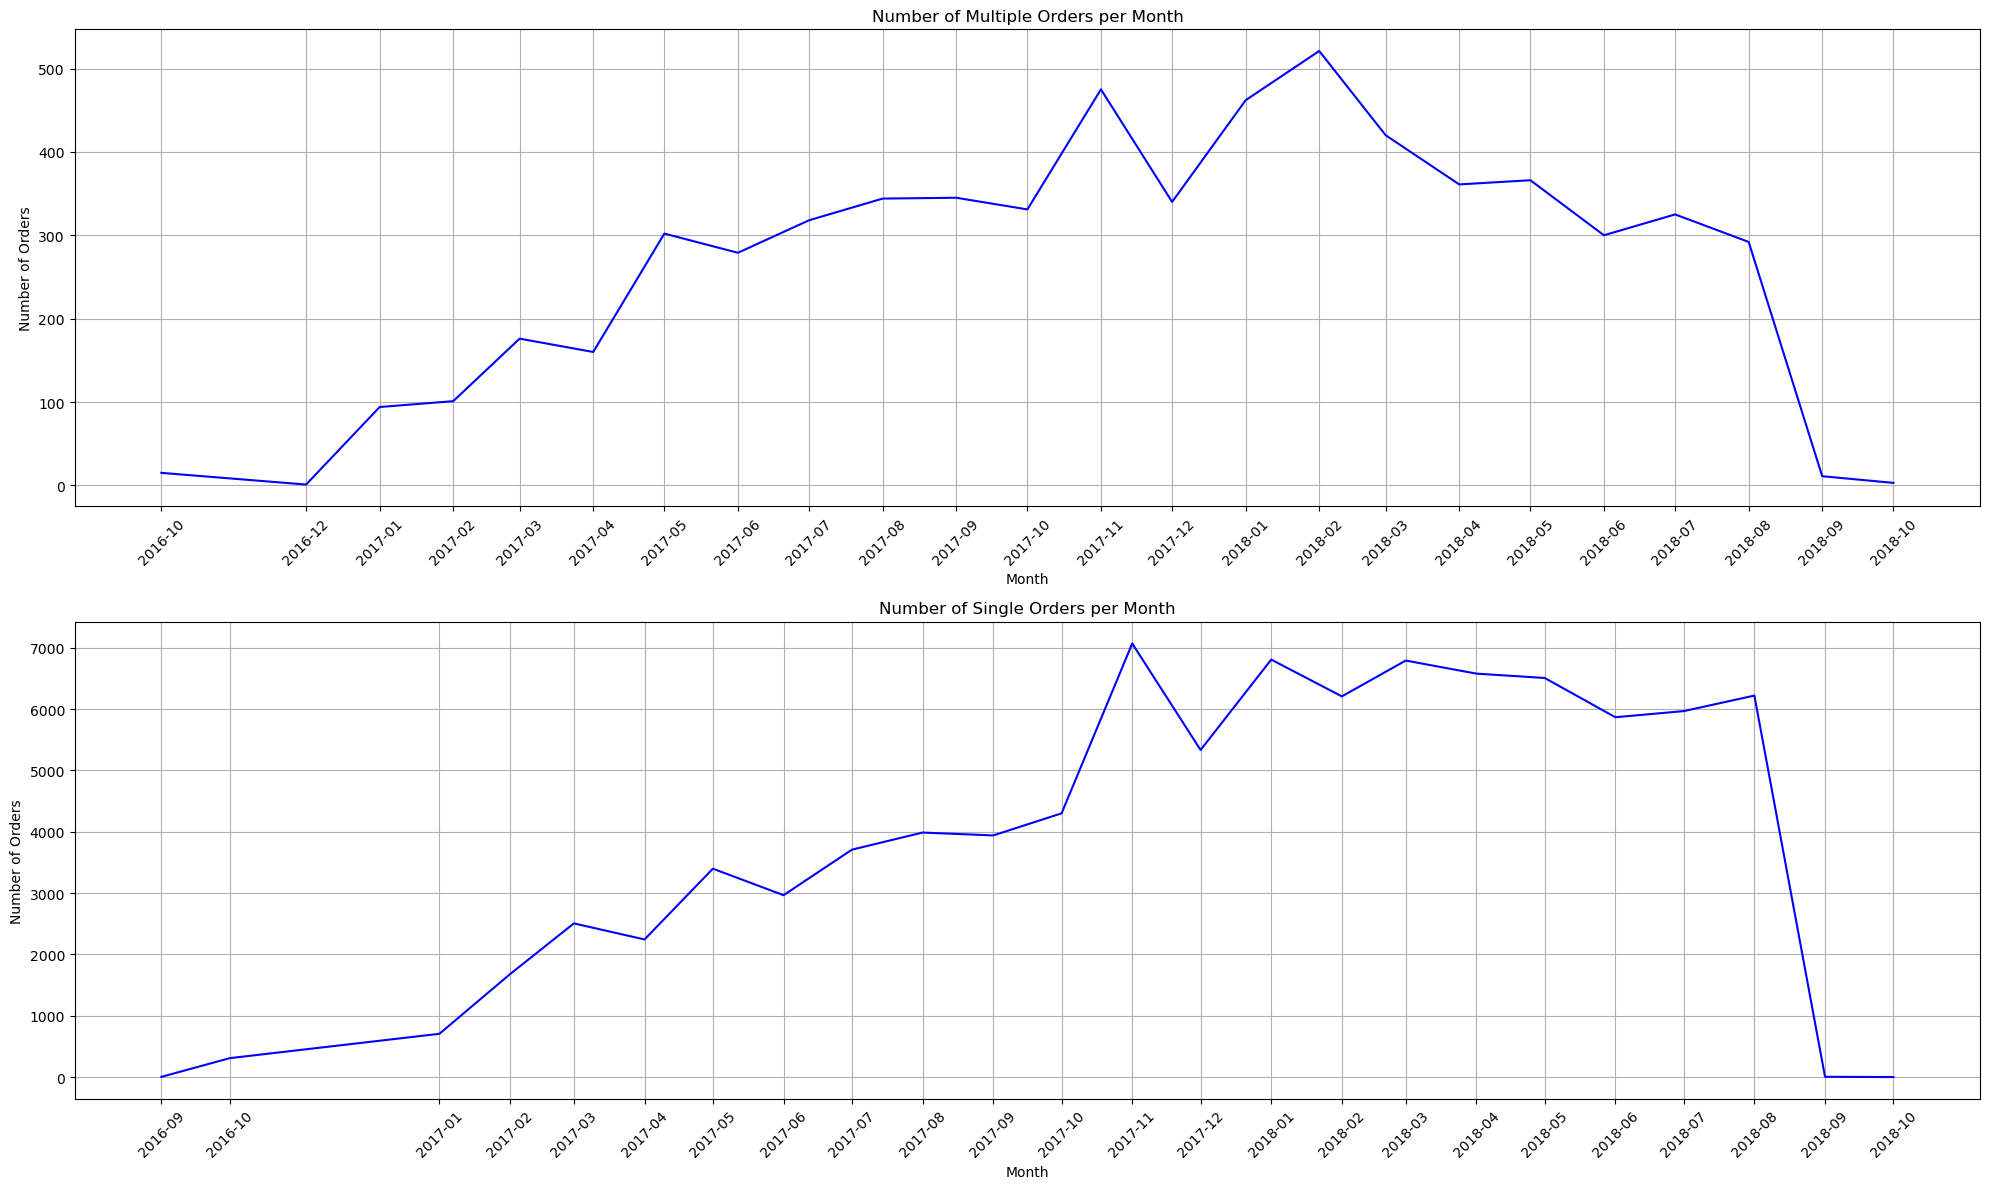

In [187]:
# Set up the plot with two subplots
fig, ax = plt.subplots(2, 1, figsize=(20, 12))
# Create the line chart
linechart(ax[0], df_mo, 'order_id', 'order_purchase_timestamp', 
          'Number of Multiple Orders per Month', 
          'Month', 'Number of Orders', 7)

linechart(ax[1], df_so, 'order_id', 'order_purchase_timestamp', 
          'Number of Single Orders per Month', 'Month', 'Number of Orders', 7)

plt.tight_layout()
plt.show()

### **Summary**
From the above graph we can see that the trendline for both Multiple orders and Single Orders is actually similar, until after 2017-12. From here, Multiple Orders experiences a 2nd spike in total orders per month before following a decreasing trend. Meanwhile, SIngle orders made remained consistent throughout that period. Both trends seem to crash at 2018-09 onwards, indicating that some unecessary information could be found there. Furthermore, the fact that there are 2 peaks instead of 1 would indicate that within that certain timeframe, some effect has urged buyers to make a repurchace

## Distribution of Order Status:
In this section we look at the distribution of that order statuses. Depending on what it shows, it can give us a good understanding on consumer preferences

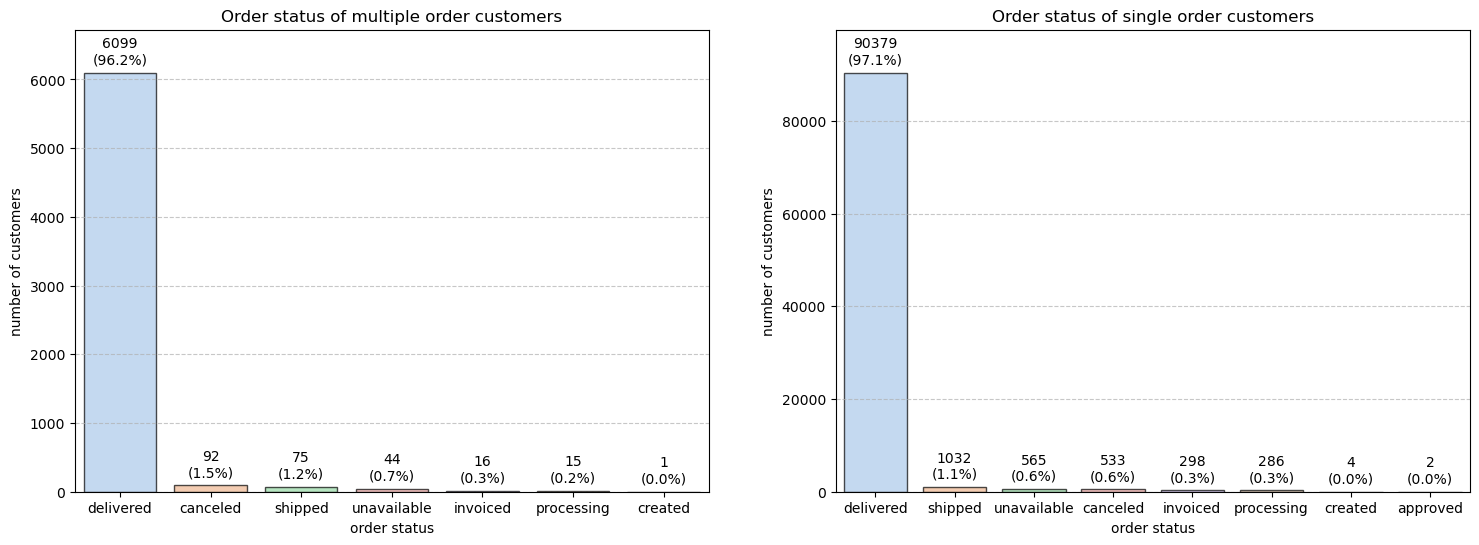

In [188]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))

barchart_eda(axs[0], df_mo, 'order_id', 'order_status', 
             'Order status of multiple order customers', 'order status', 
             'number of customers', 1)
barchart_eda(axs[1], df_so, 'order_id', 'order_status', 
             'Order status of single order customers', 'order status', 
             'number of customers', 1)

### **Summary**
In both datasets, majority of the orders are `delivered` already sitting at 96.6% and 97.2% for multiple orders and single orders respectively. The rest of the order statuses occupy no more than **4% of each dataset**. This tells us that almost all orders are successfully delivered and ensures that customers receive their items

In this distribution, across all order statuses, the % composition is almost consistent with each other with the major exception of 2 order statuses: `Canceled` and `approved`
- For those with multiple orders, the amount of `Canceled` statuses is double that of those with single orders. 
- Another is with order status `approved`, which only exists in the single order dataset

From here, it would make sense to remove the 4% of order statuses as these processes do not represent much. Removal of such noise would be beneficial to the model as it reduces the dimensionality of data without sacrificing accuracy or meaning.

## Distribution of Reviews

Distribution of reviews can tell us the sentiment of the customers on E-Commerece

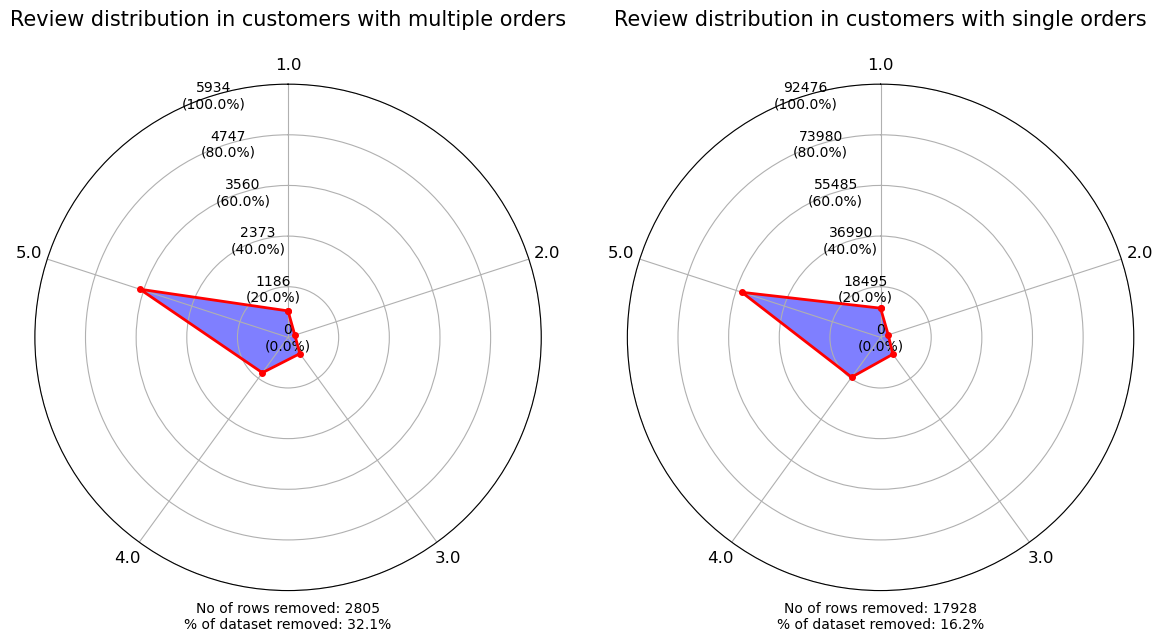

In [189]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(polar=True))

radial_chart(df_mo, 'review_score', axs[0], 
             'Review distribution in customers with multiple orders')
radial_chart(df_so, 'review_score', axs[1], 
             'Review distribution in customers with single orders')

plt.tight_layout()
plt.show()

### **Summary:**
From here, we can see that the distribution of reviews are almost proportional with each other, as shown by the red dots on the radial graph:
1) 60% line for a score of 5
2) 20% for the score of 4
3) About 10% for the score of 3 and 1
4) About 2-5% for the score of 2

The fact that 80% of all customer left positive reviews (>3) would indicate that customers are content and happy with buying from e-Commerce

However, a large potion of repeat buyers did not leave a review, as shown by the 30% of data removed from that section. This is double that of buyers in the single order. Without a review, it would make it hard to gauge whether the product is well recevied by the customer.

## Distribution of product categories:

Here we look at the distribution of products bought between each dataset. There is a possibility that some items, like electronics, can be just purchased once while daily necessities may be purchased multiple times

In [190]:
# Matching Product Category names with the translation for error checking
tr_list , ntr_list, summary = [], [], []
portugese = df['product_category_name'].unique().tolist()

for i in portugese:
    if i in tr_df['product_category_name'].values:
        tr_list.append(tr_df[tr_df['product_category_name'] == i] \
                            ['product_category_name_english'].values[0])
    else:
        ntr_list.append(i)

summary.append({
    "Number of Categories in DF": len(portugese),
    "Number of Translations": len(tr_list),
    "Number of Not Translated Categories": len(ntr_list),
    "Not Translated categories": ntr_list
})

# Create DataFrame
with pd.option_context('display.max_colwidth', None):
    display(pd.DataFrame(summary))

,Number of Categories in DF,Number of Translations,Number of Not Translated Categories,Not Translated categories
0,74,71,3,"[nan, portateis_cozinha_e_preparadores_de_alimentos, pc_gamer]"


### Translation Code

In [191]:
# This code only works in Google Colab (because I didnt link the google API token into my ipynb as it costs money to run)
# translator, tred_list = Translator(), []
# for i in ntr_list:
#     if isinstance(i, str):
#         i = i.replace("_", " ")
#         translation = translator.translate(i, src='pt', dest='en')
#         translation = translation.text.replace(" ", "_")
#         tred_list.append(translation)
# print(tred_list)

The above shows whether there are translations not accounted for, which shows 2 untranslated and a null value. Unfortunately, on a ipynb notebook in my vscode, i was unable to get the code for the google translate module to work. But anyways the translatons (from google translate) for the 2 untranslated are as follows:
- `portateis_cozinha_e_preparadores_de_alimentos`: *portable kitchen and food preparation devices* *(Kitchen_Portable_and_Food_Preparers if using colab translate)*
- `pc_gamer`: *gaming pc* *(PC_Gamer if using colab translate)*

### Graph

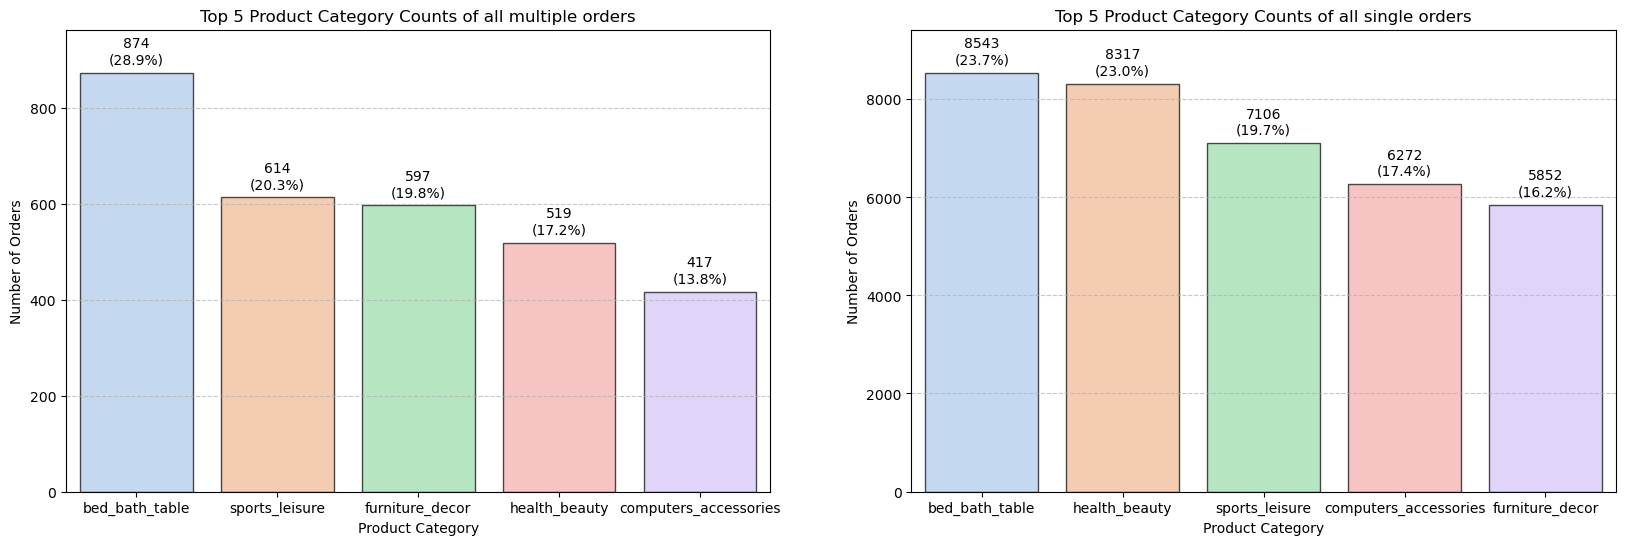

In [192]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))

barchart_eda(axs[0], df_mo, 'product_category_name', 'order_id', 
             'Top 5 Product Category Counts of all multiple orders', 
             'Product Category', 'Number of Orders', 2)
barchart_eda(axs[1], df_so, 'product_category_name', 'order_id', 
             'Top 5 Product Category Counts of all single orders', 
             'Product Category', 'Number of Orders', 2)

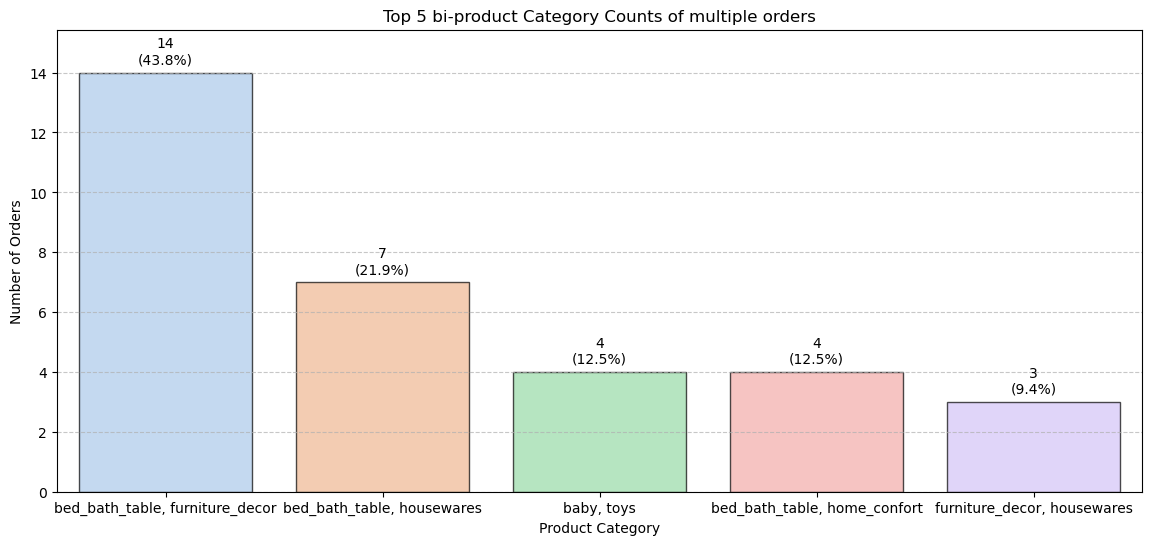

In [193]:
fig, axs = plt.subplots(figsize=(14, 6))
barchart_eda(axs, df_mo, 'product_category_name', 'order_id', 
             'Top 5 bi-product Category Counts of multiple orders', 
             'Product Category', 'Number of Orders', 3)

### **Summary:**
From this it is surprising that the top 5 categories that appear in both single and multiple orders are identical, with an exception to the proportion of the dataset it takes up. 

Accordingly are the findings:
1) **bed bath table** *(this seems to be a company)* has the highest proportion of orders in both single and multiple orders sitting at almost 30% of all multiple orders and 24% of all single orders
2) **sports leisure** takes up almost the same proportion in both datasets, at ~20%.
3) **furniture decor** takes up 20% of all multiple orders while it takes up 16% of single orders
4) **health beauty** takes up 17% of all multiple orders while taking up 23% of the single orders
5) **computer accessories** takes up 14% of the multiple orders while it takes up 17% for single orders

Out of all product bought, it seems that mostly furniture and accessories are bought. However, without the information of what the product itself is (as its demonimated by the product id without a reference), it is hard to determine what type of products are bought. If we look at the combination of 2 products bought, it does not amount to much of the dataset if any, meaning that between categories bought, there is not much meaning we can extract from it

## Payment methods

Here payment methods may be more favoured by certain individuals. Some companies accept different types of payment, which to the customer translates into convenience

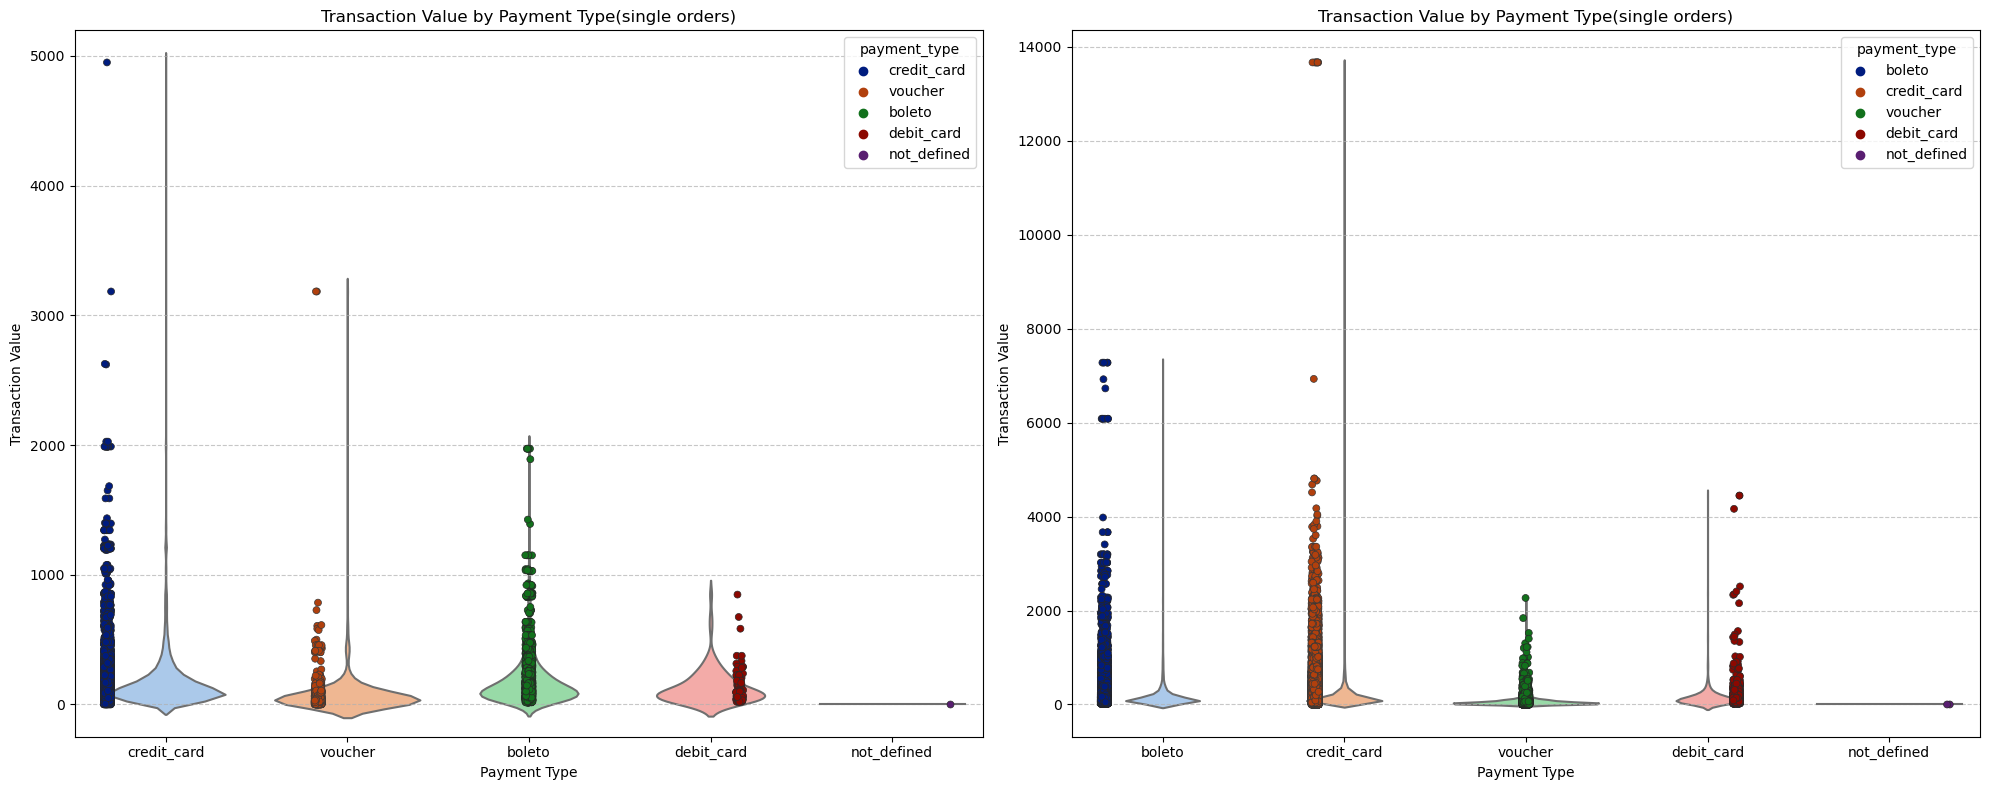

In [194]:
# Create 3 subplots in a row
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
x, y = 'payment_type', 'payment_value'
title1 = 'Transaction Value by Payment Type(multiple orders)'
title2 = 'Transaction Value by Payment Type(single orders)'
xlabel, ylabel = 'Payment Type', 'Transaction Value'
# Multiple orders plot
viol_plot(axs[0], df_mo, x, y, title1, xlabel, ylabel)
strip_plot(axs[0], df_mo, x, y, title2, xlabel, ylabel)

# Single orders plot
viol_plot(axs[1], df_so, x, y, title2, xlabel, ylabel)
strip_plot(axs[1], df_so, x, y, title2, xlabel, ylabel)

# Display
plt.tight_layout()
plt.show()

### **Summary:**
From this graph, we can see that by value, the transaction value per payment is generally below $5k. However in the case for single orders, it reaches a max of ~$7000 (excluding that outlier in credit card). This could possibly mean that most transactions for repeat buyers are low value purchaces. This would make sense has for high value purchaces, people would rather make one off payments. Meanwhile people would have no problems making multiple small purchases. 

## Distribution of prices & freight value

By looking at prices & freight value, we can see the distribution of orders and whether freight value affects the pricing of orders

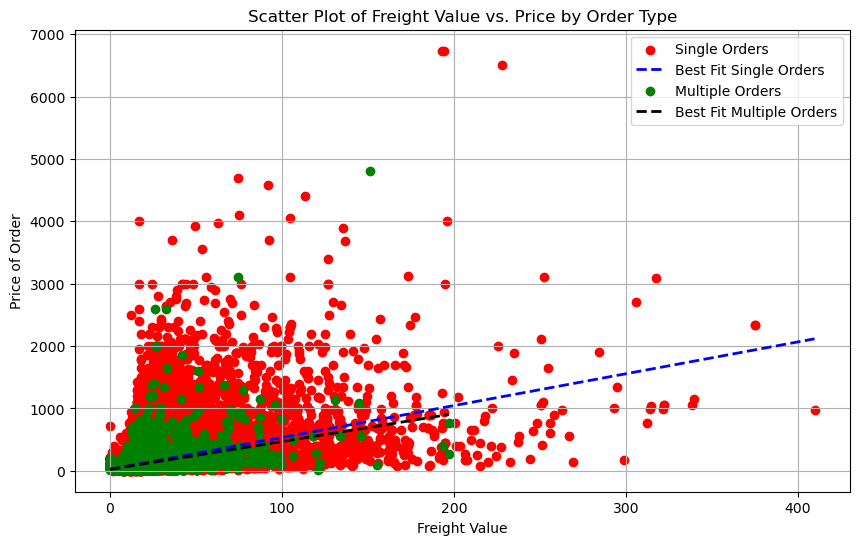

In [195]:
# Plot the scatter plot for unique data
plt.figure(figsize=(10, 6))
key, v1, v2 = 'order_id', 'price', 'freight_value'
color1, color2 = 'red', 'green'
label1, label2 = 'Single Orders', 'Multiple Orders'
scatter_plot(df_so, key, v1, v2, color1, label1)
scatter_plot(df_mo, key, v1, v2, color2, label2)
plt.xlabel('Freight Value')
plt.ylabel('Price of Order')
plt.title('Scatter Plot of Freight Value vs. Price by Order Type')
plt.legend()
plt.grid(True)
plt.show()

### **Summary**
From this graphical distribution, we can see 2 things:
1) The Freight Value for majority of multiple orders made are between 0-100, while for single orders majority is between 0-200
2) Freight value is not proportional to Price of order, but shares a positive relationship (as freight value increases, price of order does not increase as much)

It would seem that what would affect customer's repurchasing would be the freight value for the price of order, as we can see the distribution of green dots it clumps mostly between 0-100. It would make sense as one time purchaces would be made at larger values compared to multiple low value purchaces.

## Date of delivery

Here we look at delivery, whether orders are delivered on time or not. Normally a late delivery would result in unhappy customers, while early deliveries would make happy customers. Furthermore, with the knowledge that some orders are not completed, it may provide valuable insight.

In order to get this, we would need to deconstruct the datetime datafields, and then obtain when its delivered, its expected arrival and after all that, add it into 2 new columns, 'Early or Late', 'Days'

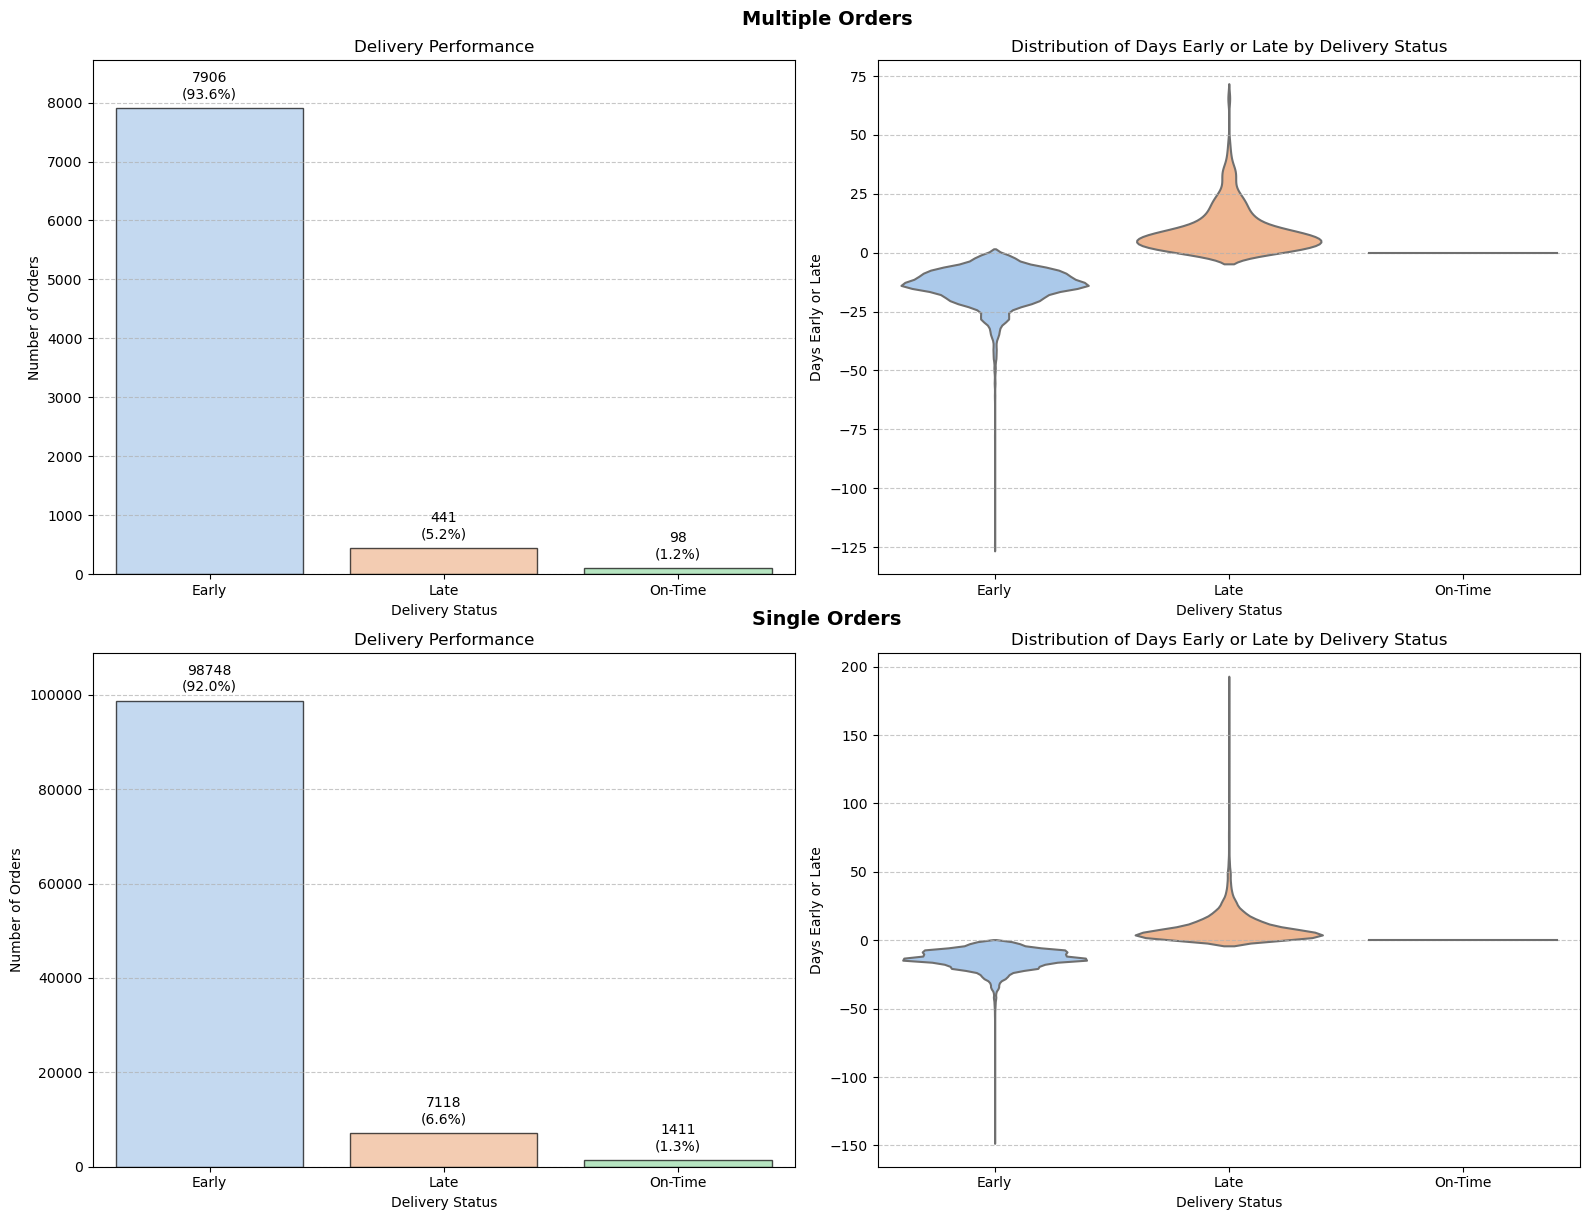

In [196]:
# Set up the 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

barchart_eda(axes[0,0], df_mo, 'order_id', 'order_delivered_customer_date', 'Delivery Performance', 'Delivery Status', 'Number of Orders', 4)

# Category 1: Multiple Orders
fig.text(0.52, 1, 'Multiple Orders', horizontalalignment='center', fontsize=14, fontweight='bold')

# Violin Plot w processing
temp_df = processing(df_mo, 'order_id', 'order_delivered_customer_date', 5)
viol_plot(axes[0, 1], temp_df, 'Early or Late', 'Days', 'Distribution of Days Early or Late by Delivery Status', 'Delivery Status', 'Days Early or Late')

# Category 2: Single Orders
fig.text(0.52, 0.5, 'Single Orders', horizontalalignment='center', fontsize=14, fontweight='bold')

barchart_eda(axes[1,0], df_so, 'order_id', 'order_delivered_customer_date', 'Delivery Performance', 'Delivery Status', 'Number of Orders', 4)

temp_df = processing(df_so, 'order_id', 'order_delivered_customer_date', 5)
viol_plot(axes[1, 1], temp_df, 'Early or Late', 'Days', 'Distribution of Days Early or Late by Delivery Status', 'Delivery Status', 'Days Early or Late')

plt.tight_layout()
plt.show()

### **Summary**
Here we can see that majority of orders are actually early between single and multiple orders. Additionally, the distribution of values are almost the same for both. Majority of orders are delivered early before the 25th day and those orders that were late was also resolved during that period. However, there are outliers, of which there is a product that was delivered 150 days earlier and another delivered 200 days late. 

## Geospatial Analysis
Unfortunately, geospatial analysis is quite complicated in machine learning. The hardest part is actually handling the different states. Interestingly, by using this geospatial information we can actually derive further insights from what we haev already done. 

For processing geospatial information, we ignore lat/long as I dont plan on making a map. Additionaly as shown at the start of the eda, we ignore geolocation_city as simply, 

**Data Processing**

In [198]:
# This time, we drop duplicates at the zip_code_level
ori = location_df['geolocation_zip_code_prefix'].shape[0]
change = location_df['geolocation_zip_code_prefix'].drop_duplicates().shape[0]

print("Location DF entries:", ori)
print("Location DF drop dupes:", change)
print("No. of columns removed:", ori-change)

Location DF entries: 738332
Location DF drop dupes: 19015
No. of columns removed: 719317


From here, we can see that a lot of zip codes are actually duplicated. This means that the initial processing of dropping duplicates was not sufficient enough. Additionally, it also does mean that perhaps lat/long will only be useful in generating a map of precise coordinates.

In [199]:
# To make the changes permanent
location_df = location_df.drop_duplicates(subset='geolocation_zip_code_prefix')
location_df = location_df.drop(['geolocation_lat','geolocation_lng',
                                'geolocation_city'], axis=1)

In [200]:
# Data Processing
def merge_location(df):
    # Merge location df to df by customer
    temp_df = df.merge(location_df, 
                       left_on='customer_zip_code_prefix', 
                       right_on='geolocation_zip_code_prefix', 
                       how='left')
    # Rename manually
    temp_df.rename(columns={'geolocation_state': 'customer_state'}, 
                     inplace=True)
    # Remove the added column
    temp_df.drop(columns=['geolocation_zip_code_prefix'], 
                   inplace=True)
    
    # Drop rows with NaN values in the 'seller_zip_code_prefix' column
    temp_df.dropna(subset=['seller_zip_code_prefix'], inplace=True)

    # Change datatype
    temp_df['seller_zip_code_prefix'] = temp_df['seller_zip_code_prefix'] \
                                               .astype('int64')

    temp_df = temp_df.merge(location_df, 
                            left_on='seller_zip_code_prefix', 
                            right_on='geolocation_zip_code_prefix', 
                            how='left')
    
    # Rename again manually
    temp_df.rename(columns={'geolocation_state': 'seller_state'}, inplace=True)

    # Remove the added column
    temp_df.drop(columns=['geolocation_zip_code_prefix'], inplace=True)

    return temp_df

In [201]:
df_mo = merge_location(df_mo)
df_so = merge_location(df_so)

Now we can see where most customers and sellers originate from.

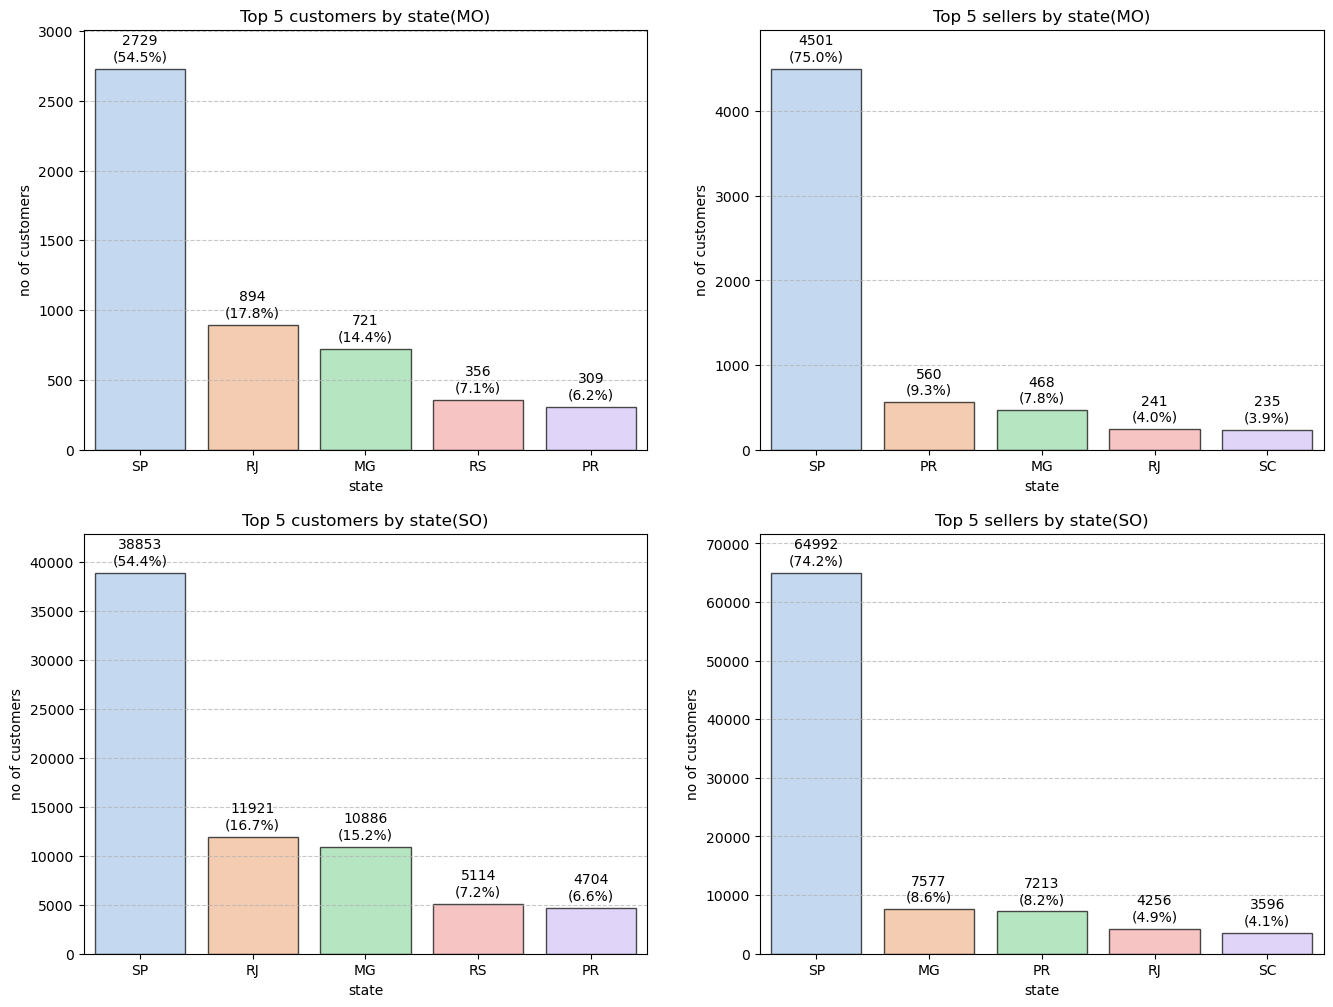

In [202]:
# Set up the 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
barchart_eda(axes[0, 0], df_mo, 'order_id', 'customer_state', 
             'Top 5 customers by state(MO)', 'state', 'no of customers', 6)
barchart_eda(axes[0, 1], df_mo, 'order_id', 'seller_state', 
             'Top 5 sellers by state(MO)', 'state', 'no of customers', 6)

barchart_eda(axes[1, 0], df_so, 'order_id', 'customer_state', 
             'Top 5 customers by state(SO)', 'state', 'no of customers', 6)
barchart_eda(axes[1, 1], df_so, 'order_id', 'seller_state', 
             'Top 5 sellers by state(SO)', 'state', 'no of customers', 6)

### **Summary:**
Suprisingly, between the sellers and the customers for both datasets, the proportions for each state for the top 5 customers and sellers are actually almost consistent with each other. This does mean that state may not have a significant impact as its thought.

## States that do not appear in both datasets

In [203]:
state_list = location_df['geolocation_state'].unique().tolist()

In [204]:
# Find which states from states_list are not present in the DataFrame
missing_states1 = [state for state in state_list if
                   state not in df_mo['customer_state'].values]
missing_states2 = [state for state in state_list if 
                   state not in df_mo['seller_state'].values]
missing_states3 = [state for state in state_list if 
                   state not in df_so['customer_state'].values]
missing_states4 = [state for state in state_list if 
                   state not in df_so['seller_state'].values]

summary=[]
summary.append({
    'States w/o customers(MO)': missing_states1,
    'States w/o sellers(MO)': missing_states2,
    'States w/o customers(SO)': missing_states3,
    'States w/o sellers(SO)':missing_states4
    })

# Prevent the DataFrame from being truncated
pd.set_option('display.expand_frame_repr', False)
pd.DataFrame(summary)

,States w/o customers(MO),States w/o sellers(MO),States w/o customers(SO),States w/o sellers(SO)
0,[],"[SE, AL, PB, PI, PA, AP, AM, RR, AC, TO]",[],"[AL, PA, AP, RR, TO]"


### Summary
From here we can see that some states have no sellers, however customers are found in all unique states

## Feature Engineering
Now that we have concluded the eda we need to identify how to split our data. Knowing that many features are proportional helps. Afer that it would be splitting the data into train test validate. This will show us a gague of how much of each dataset is represented and whether we can prevent it from being a biased model. Furthermore, there were many problems with split data, especially with having duplicate rows simply becasue of payments

What will be done here:
1) Creating the `repurchase` variable indicating customers that have bought 
2) Removing the multiple entries from payments by condensing the information into simple columns
3) Taking only delivered orders to completely handle majority of errors
4) Getting whether orders are delivered early or late as well as by their value
5) Final check by ensuring that the sum of payments is equal to the price and freight value of the order
6) Dropping all unused or processed columns

**Step 1**

In [205]:
df_mo['repurchase'] = 1
df_so['repurchase'] = 0
df = pd.concat([df_mo, df_so], ignore_index=True)

**Step 2**

In [206]:
# Group by order_id and calculate the number of payments, unique payment methods, and sum of payment values
result = df.groupby('order_id').agg(
    number_of_payments=('payment_type', 'count'),
    payment_methods=('payment_type', 'nunique'),
    total_payment_value=('payment_value', 'sum'),
    no_of_categories=('product_category_name', 'nunique'),
    sellers=('seller_id','nunique')
).reset_index()

# Additional calculation for items bought and max order item id within product categories
basket_info = df.groupby(['order_id', 'product_category_name']).agg(
    max_order_item_id=('order_item_id', 'max')
).reset_index()

# Sum up the max order item ids to get the total number of items per order
total_items = basket_info.groupby('order_id')['max_order_item_id'] \
                         .sum().reset_index()
total_items.rename(columns
                   = {'max_order_item_id': 'total_items'}, inplace=True)

# Merge the total items back into the result
result = result.merge(total_items, on='order_id')

# Merge the result into the actual dataset
temp_df = df.drop_duplicates(subset=['order_id'])
final_df = temp_df.merge(result, left_on='order_id', right_on='order_id', 
                         how='left')

**Step 3**

In [207]:
final_df = final_df[final_df['order_status']=='delivered']

**Step 4**

In [208]:
# Convert columns to datetime, coerce errors to NaT
final_df['order_delivered_customer_date'] = pd.to_datetime \
                                            (final_df \
                                            ['order_delivered_customer_date'], 
                                            errors='coerce')
final_df['order_estimated_delivery_date'] = pd.to_datetime \
                                            (final_df['order_estimated_delivery_date'], 
                                            errors='coerce')

# Drop rows with NaT values
final_df = final_df.dropna()

# Convert to date only (exclude time)
final_df['delivered_date'] = final_df['order_delivered_customer_date'] \
                            .dt.date
final_df['estimated_date'] = final_df['order_estimated_delivery_date'] \
                            .dt.date

# Calculate 'Early, Late, or On-Time' and 'Days'
final_df['Early or Late'] = final_df.apply(classify_delivery, axis=1)
final_df['Days'] = (final_df['delivered_date'] 
                    - final_df['estimated_date']).apply(lambda x: x.days)

**Step 5**

In [209]:
final_df = final_df[(final_df['price'] 
                     + final_df['freight_value']) 
                     == final_df['total_payment_value']]

**Step 6**

In [210]:
final_df.drop(
    columns=['order_id', 'order_status', 'order_purchase_timestamp',
             'order_delivered_customer_date', 'order_estimated_delivery_date',
             'customer_unique_id','customer_zip_code_prefix', 
             'payment_type', 'payment_installments', 'payment_value', 
             'review_id', 'product_category_name', 'product_description_lenght', 
             'order_item_id', 'seller_id', 'product_id', 'product_photos_qty', 
             'product_weight_g', 'product_length_cm', 'product_height_cm', 
             'product_width_cm', 'seller_zip_code_prefix', 'delivered_date', 
             'estimated_date', 'customer_state','seller_state', 
             'Early or Late', 'total_payment_value'],
             axis=1, inplace=True)
# Note: Columns not dropped in order

### **Summary:**
After this we will look at the difference between when we first started and also use PCA to see if after all our cleaning our variables are all relevant

In [211]:
# PCA Code goes here so my summary is cleaner
# Standardize the features
features = final_df.columns
x = final_df.loc[:, features].values
x = StandardScaler().fit_transform(x)

# Perform PCA
pca = PCA(n_components=min(len(features), len(final_df)))
principalComponents = pca.fit_transform(x)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
pca_df = pd.DataFrame(loadings, 
                      columns=[f'PC{i+1}' for i in range(loadings.shape[1])], 
                      index=features)

In [212]:
# Calculate the correlation matrix
correlation_matrix = final_df.corr()

# Summary
## **Dataset Information**

In [213]:
final_df.head(3)

,review_score,price,freight_value,repurchase,number_of_payments,payment_methods,no_of_categories,sellers,total_items,Days
0,4.0,29.99,8.72,1,3.0,2.0,1.0,1.0,1.0,-8
4,4.0,36.90,17.92,1,1.0,1.0,1.0,1.0,1.0,-18
5,1.0,84.90,14.36,1,1.0,1.0,1.0,1.0,1.0,7


In [214]:
summary = []
summary.append({
    'Original Dataset:': original_df_size,
    'Final Dataset': final_df.shape,
    'Rows Removed': (original_df_size[0]-final_df.shape[0]),
    'Columns Removed': (original_df_size[1]-final_df.shape[1])
})
pd.DataFrame(summary)

,Original Dataset:,Final Dataset,Rows Removed,Columns Removed
0,"(119143, 25)","(67902, 10)",51241,15


In [215]:
final_df.repurchase.value_counts()

repurchase
0    64029
1     3873
Name: count, dtype: int64

## **PCA & Correlation Matrix**
The idea is that PCA and correlation matrix should produce about the same results when it comes to covaraince.

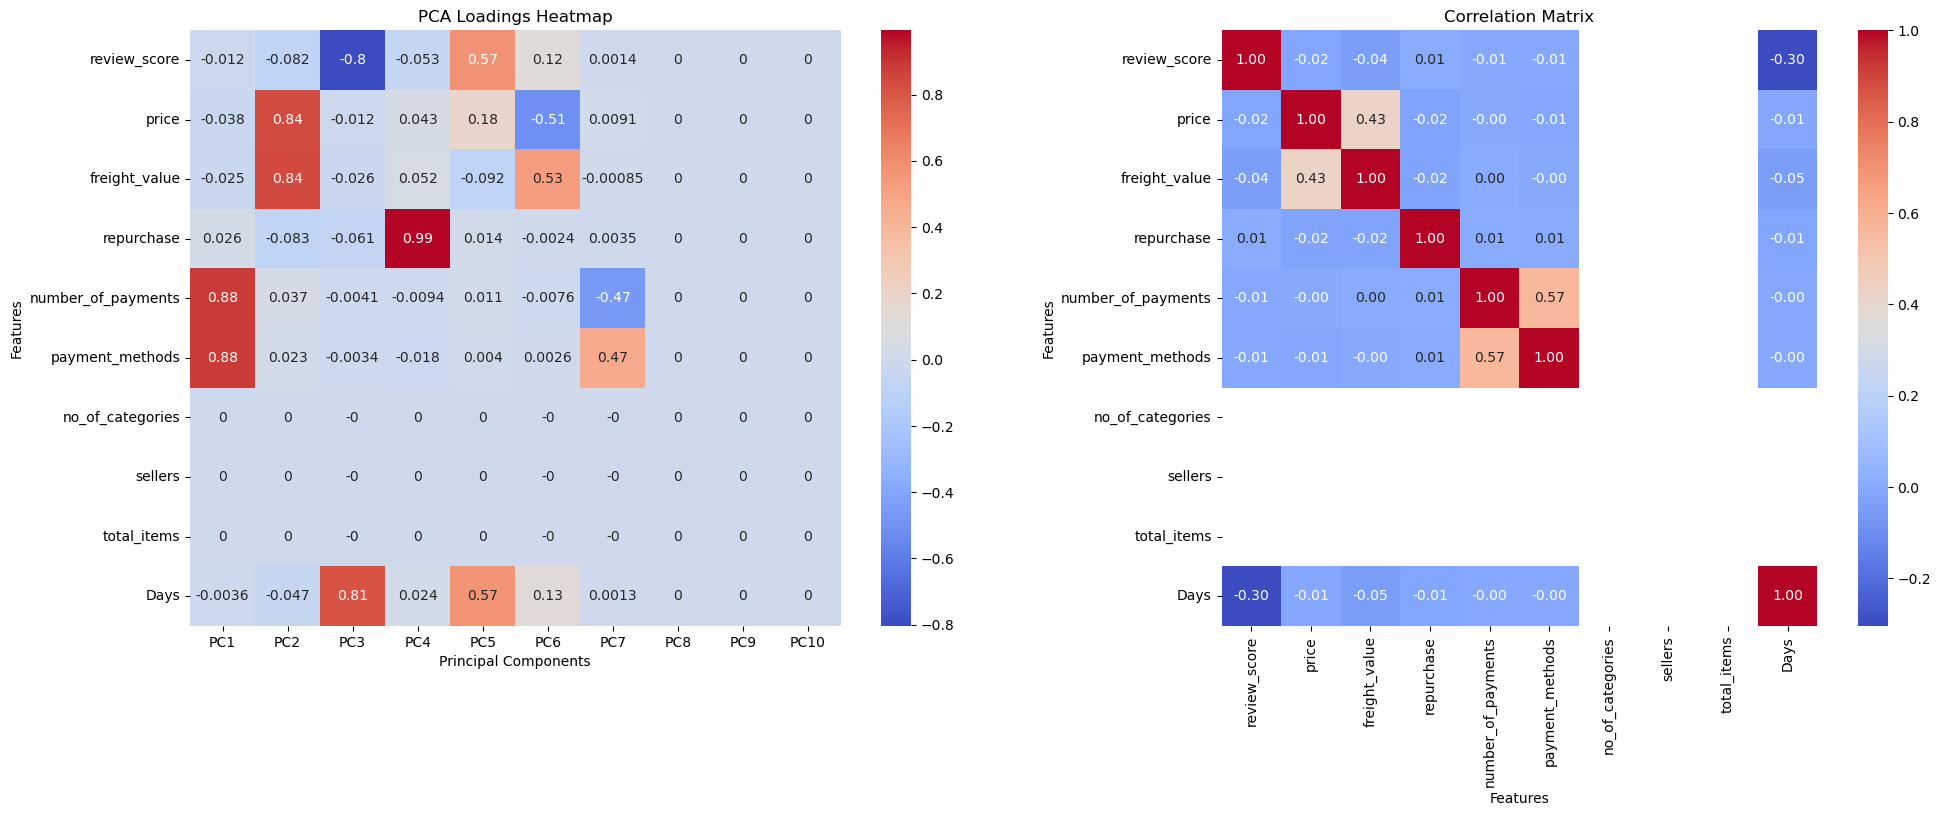

In [216]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot PCA Loadings Heatmap
sns.heatmap(pca_df, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title('PCA Loadings Heatmap')
axes[0].set_xlabel('Principal Components')
axes[0].set_ylabel('Features')

# Plot Correlation Matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, ax=axes[1])
axes[1].set_title('Correlation Matrix')
axes[1].set_xlabel('Features')
axes[1].set_ylabel('Features')

plt.tight_layout()
plt.show()

### **Features Analysis(PCA)**

PCA helps us identify the direction of relationship each factor has. A positive PCA indicates that the variables move in the same directions *(i.e. if 1 increases the other increases accordingly, same with decreasing)*, a negative PCA indicates the variables move in opposite directions *(i.e. 1 increases, the other decreases)*

***review_score:***

Has significant negative loadings on PC3 (-0.8) and positive loadings on PC5 (0.57) and PC6 (0.12).

***price:***

Has significant loadings on PC1 (0.84), indicating a strong contribution.

***freight_value:***

Similar to price, has significant loadings on PC1 (0.84).

***repurchase:***

Has a significant loading on PC4 (0.99).

***number_of_payments:***

Has significant loadings on PC1 (0.88) and a negative loading on PC7 (-0.47).

***payment_methods:***

Has significant loadings on PC1 (0.88) and PC7 (0.47).

***Days:***

Has significant loading on PC3 (0.81) and some contributions to PC5 (0.57) and PC6 (0.13).
This feature has some relevance and shouldn't be dropped.

Everything above should be kept as they each have some relevance tied to them

***no_of_categories, sellers, total_items:***

Has zero loadings across all principal components & correlation matrix.
These feature does not contribute to any principal components and can be dropped.

### **Features Analysis(CorrMatrix)**

Correlation Matrix tells as which 2 factors are correlated or not. Based from our EDA, the factors we select should have correlations between each other.

***Days and review score***
Returns a -0.30 correlation, indicating that the days late or early lightly impact the review score given.

***Freight value and price***
Returns a 0.43 correlation, indicating that generally, as price increases, freight value increases, same as our EDA. 

***Payment methods and number of payments***
Returns a 0.57 correlation, indicating that more payments is a resultant of payment methods. 

***no_of_categories, sellers, total items***
Returns no correlation, indicating that these should be dropped

### **Conclusion**

Based on the analysis, we will drop the following features:

- no_of_categories
- sellers
- total_items


These features have zero loadings across all principal components and correlation analysis and do not contribute to the variance captured by the PCA and relationship from the correlation matrix. Dropping these features can simplify the model without losing significant information.

# Summary of key findings
## From analysis of trends
1) Certain factors can affect the seasonal demand of goods from customers, as shown by the 2 peaks in the distribution of orders bought over time. During that period it seems that is where majority of people has reordered. 

2) In the whole dataset, almost all orders (95%) is delivered, giving us a good starting point to just keep all delivered orders.

3) Generally people were contented with the deliveries by giving high review scores. However, the fact that in those re-ordered sections do indicate that low reviews were given means that not all sellers has the same and consistent service

4) Between the type of product bought, there is not a big difference in the top 5 items bought. The total of the top 5 categories consist of bed bath table, sports & leisure, furniture & decor, health & beauty and computer accessories

5) As for payments, the amount and spread of each type is about the same in terms of its monetary value, meaning that as the cost of payment increases, so does they type of mayment method they use.

6) As for price and freight value, both datasets show a positive relationship with each other, albeit at a very gentle rate of increase possibly due to outliers. However, multiple orders made generally are below 100 frieght value and 1000 order value. 

7) As for date of delivery, the spread of early and late orders are similar, with majority being early. THis does affect the order rate, but in terms of repeated orders, doesnt show a good representation

8) The relative amount of sellers and buyers in each state doesnt vary much, leading us to belive that it is not important in E-commerce

## From the data itself
1) the number of categories, number of items bought and number of sellers dont matter from the correlation matrix.

2) Days & Review score, Frieght Value & Price, Payment method and number of payments have some correlation between each other.

## Dataset Changes
1) 50k rows removed, from 119143 entries to 67902
2) Columns removed, from 25 to 10
3) Eventually we will remove 3 more columns (number of categories, number of items bought and number of sellers)